In [1]:
import ROOT
import numpy as np
import pprint
from glob import glob
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import re

import sys
sys.path.append('..')
from common import common
print(common.quantities)

Welcome to JupyROOT 6.16/00
['pT_yy', 'yAbs_yy', 'Dphi_j_j_30_signed', 'pT_j1_30', 'N_j_30', 'm_jj_30']


In [2]:
def loop_iterator(iterator):
  object = iterator.Next()
  while object:
    yield object
    object = iterator.Next()

def iter_collection(rooAbsCollection):
  iterator = rooAbsCollection.createIterator()
  return loop_iterator(iterator)

def sorting_key(elemList):
    return len(elemList[0])

def create_dir_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [225]:
quantity = "m_jj_30"
dataset = "AsimovSB"
method = 'binbybin'
workspace_folder = "../output/quickFit_binbybin/%s" % quantity

In [227]:
def extend_bin_labels(bin_labels, binning, add_underflow, add_overflow):
    """
    bin_labels: bin labels without under/overflow
    binning: binning without under/overflow
    """
    result = bin_labels[:]
    if add_overflow:
        result.append(r"$\geq %.1f$" % binning[-1])
    if add_underflow:
        result = [r"$< %.1f$" % binning[0]] + result
    return result

def get_binning_for_plot(binning):
    binning = np.copy(binning)
    if binning[-1] == np.inf:
        binning[-1] = (binning[-2] - binning[-3]) + binning[-2]
    if binning[0] == -np.inf:
        binning[0] = binning[1] - (binning[2] - binning[1])
    return binning

def remove_under_overflow(data, do_underflow, do_overflow):
    """
    given an array return a copy removing the first and/or the last element,
    depending on the flags
    """
    data = np.copy(data)
    if not do_overflow:
        data = data[:-1]
    if not do_underflow:
        data = data[1:]
    return data

In [228]:
latex_label = common.latex_labels[quantity]
binning = np.array(common.binnings[quantity])       # without under/over-flow
bin_labels = common.bin_labels[quantity]            # without under/over-flow
show_overflow = common.show_overflows[quantity]
show_underflow = common.show_underflows[quantity]

do_normalization = common.do_normalizations[quantity]
do_log_x = common.do_logs_x[quantity]
unit = common.unities_root_file[quantity]

if unit == 'MeV':
    binning /= 1000.

binning_with_extraflow = np.concatenate([[-np.inf], np.array(binning), [np.inf]])
bin_labels_extraflow = extend_bin_labels(bin_labels, binning, add_overflow=True, add_underflow=True)

# add -inf, +inf to the binning if needed
binning_with_extraflow = np.copy(np.array(binning))
if show_underflow:
    binning_with_extraflow = np.append(-np.inf, binning_with_extraflow)
if show_overflow:
    binning_with_extraflow = np.append(binning_with_extraflow, np.inf)

# create special bins for under/over-flow
binning_plot = get_binning_for_plot(binning_with_extraflow)

bin_labels_plot = remove_under_overflow(bin_labels_extraflow, do_underflow=show_underflow, do_overflow=show_overflow)

idx = list(range(len(common.binnings[quantity]) + 1))
idx_plot = remove_under_overflow(idx, do_underflow=show_underflow, do_overflow=show_overflow)
nbins_plot = len(idx_plot)

print("quantity: %s" % quantity)
print("label: %s" % latex_label)
print("binning: %s" % binning)
print('bin-labels (no under/over-flow): %s' % ', '.join(bin_labels))
print('show overflow: %s' % show_overflow)
print('show under: %s' % show_underflow)
print('do normalization: %s' % do_normalization)
print('do log-x: %s' % do_log_x)
print('unit: %s' % unit)
print("binning with extraflow %s" % binning_with_extraflow)
print("bin labes for plots %s" % bin_labels_plot)
print("binning plot %s" % binning_plot)

quantity: m_jj_30
label: $m_{jj}^{(30)}$ [GeV]
binning: [   0.  170.  500. 1500.]
bin-labels (no under/over-flow): [0 - 170), [170 - 500), [500 - 1500)
show overflow: True
show under: False
do normalization: True
do log-x: False
unit: MeV
binning with extraflow [   0.  170.  500. 1500.   inf]
bin labes for plots ['[0 - 170)' '[170 - 500)' '[500 - 1500)' '$\\geq 1500.0$']
binning plot [   0.  170.  500. 1500. 2500.]


## Create output directory

In [229]:
output_basedir_pulls = '../output/plot-pulls/{method}/{quantity}'.format(method=method, quantity=quantity)
create_dir_if_not_exists('../output/plot-pulls/{method}'.format(method=method))
create_dir_if_not_exists(output_basedir_pulls)

output_basedir_correlation = '../output/plot-correlation/{method}/{quantity}'.format(method=method, quantity=quantity)
create_dir_if_not_exists('../output/plot-correlation/{method}'.format(method=method))
create_dir_if_not_exists(output_basedir_correlation)

output_basedir_xsections = '../output/plot-xsection/{method}/{quantity}'.format(method=method, quantity=quantity)
create_dir_if_not_exists('../output/plot-xsection/{method}'.format(method=method))
create_dir_if_not_exists(output_basedir_xsections)

In [230]:
fname_ws_fullfit = os.path.join(workspace_folder, 'XSectionWS_{quantity}-fitted_{dataset}.root'.format(quantity=quantity, dataset=dataset))
f_fullfit = ROOT.TFile.Open(fname_ws_fullfit)
fit_results_fullfit = f_fullfit.Get("fitResult")

fname_ws_statonly = os.path.join(workspace_folder, 'XSectionWS_{quantity}-statonly-fitted_{dataset}.root'.format(quantity=quantity, dataset=dataset))
f_statonly = ROOT.TFile.Open(fname_ws_statonly)
fit_result_statonly = f_statonly.Get("fitResult")


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Warning in <TClass::Init>: no dictionary for class RooTwoSidedCBShape is available


## Extracting 'fit_results' and selecting $\mu_{\sigma}$ 

In [231]:
xsections_SM = np.load("../output/xsections/{quantity}/XSections_isFiducial_notDalitz_{quantity}_mcAll_prodAll_Nominal.npy".format(quantity=quantity))
xsections_SM_to_plot = remove_under_overflow(xsections_SM, do_underflow=show_underflow, do_overflow=show_overflow)
xsections_SM

array([23.50622514,  1.96308205,  1.48372862,  0.77882878,  0.15596043])

In [232]:
def extract_info_from_fitresult(fit_results):
    fit_results_RooArgSet = fit_results.floatParsFinal()
    fit_results_collection = iter_collection(fit_results_RooArgSet)
    
    fit_results_list = []
    for fit_elem in fit_results_collection:
        fit_results_list.append([fit_elem.GetName(), fit_elem.getVal(), fit_elem.getError()])
    return fit_results_list
    
df_fullfit = extract_info_from_fitresult(fit_results_fullfit)
df_fullfit = pd.DataFrame(df_fullfit, columns=('name', 'value', 'error')).set_index('name')

df_statonly = extract_info_from_fitresult(fit_result_statonly)
df_statonly = pd.DataFrame(df_statonly, columns=('name', 'value', 'error')).set_index('name')

In [233]:
name_xsec_to_plot = np.array(['mu_xsec_{quantity}_{ibin}'.format(quantity=quantity, ibin=ibin) for ibin in idx_plot])
name_xsec_to_plot

array(['mu_xsec_m_jj_30_1', 'mu_xsec_m_jj_30_2', 'mu_xsec_m_jj_30_3',
       'mu_xsec_m_jj_30_4'], dtype='|S17')

In [234]:
df_poi_statonly = df_statonly.reindex(name_xsec_to_plot).fillna(0).copy()
df_poi_statonly['idx'] = idx_plot
df_poi_statonly = df_poi_statonly.reset_index().set_index('idx', drop=True)
df_poi_statonly['bin_label'] = bin_labels_plot
df_poi_statonly['xsectionBr'] = xsections_SM_to_plot * df_poi_statonly['value'] * common.Br
df_poi_statonly['xsectionBr_error'] = xsections_SM_to_plot * df_poi_statonly['error'] * common.Br

df_poi_fullfit = df_fullfit.reindex(name_xsec_to_plot).fillna(0).copy()
df_poi_fullfit['idx'] = idx_plot
df_poi_fullfit = df_poi_fullfit.reset_index().set_index('idx', drop=True)
df_poi_fullfit['bin_label'] = bin_labels_plot
df_poi_fullfit['xsectionBr'] = xsections_SM_to_plot * df_poi_fullfit['value'] * common.Br
df_poi_fullfit['xsectionBr_error'] = xsections_SM_to_plot * df_poi_fullfit['error'] * common.Br
df_poi_fullfit

name     value     error      bin_label  xsectionBr  \
idx                                                                     
1    mu_xsec_m_jj_30_1  0.997318  0.261860      [0 - 170)    0.004444   
2    mu_xsec_m_jj_30_2  0.995289  0.318567    [170 - 500)    0.003352   
3    mu_xsec_m_jj_30_3  0.996894  0.293850   [500 - 1500)    0.001762   
4    mu_xsec_m_jj_30_4  0.996550  0.440626  $\geq 1500.0$    0.000353   

     xsectionBr_error  
idx                    
1            0.001167  
2            0.001073  
3            0.000520  
4            0.000156

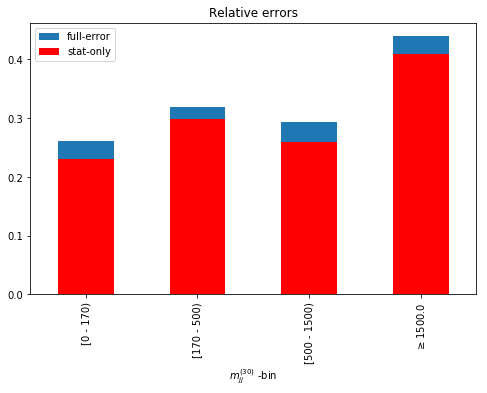

In [235]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.set_title("Relative errors")
df_poi_fullfit['error'].plot.bar(ax=ax, label='full-error')
df_poi_statonly['error'].plot.bar(ax=ax, color="r", label='stat-only')
ax.set_xticklabels(df_poi_fullfit['bin_label'])
ax.set_xlabel(common.latex_labels[quantity].replace('[GeV]', '-bin'))
ax.legend()
plt.show()

## Selecting and sorting nuisance parameters (NP)

In [236]:
df_nui_fullfit = df_fullfit.loc[df_fullfit.index.str.contains('ATLAS')]
df_nui_fullfit

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.

Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
  File "</home/mario/venv_py/local/lib/python2.7/site-packages/decorator.pyc:decorator-gen-24>", line 2, in run
  File "/home/mario/venv_py/local/lib/python2.7/site-packages/IPython/core/history.py", line 60, in needs_sqlite
  File "/home/mario/venv_py/local/lib/python2.7/site-packages/IPython/core/history.py", line 843, in run
  File "/home/mario/venv_py/local/lib/python2.7/site-packages/ipykernel/iostream.py", line 400, in write
  File "/home/mario/venv_py/local/lib/python2.7/site-packages/ipykernel/iostream.py", line 203, in schedule
  File "/home/mario/venv_py/local/lib/python2.7/site-packages/ipykernel/iostream.py", line 101, in _event_pipe
  File "/home/mario/venv_py/local/lib/python2.7/site-packages/zmq/sugar/context.py", line 146, in socket
  File "/home/mario/venv_py/local/lib/python2.7/site-packages/zmq/sugar/socket.py", l

value     error
name                                                           
ATLAS_EG_RESOLUTION_ALL                 -6.361701e-02  0.858293
ATLAS_EG_SCALE_ALL                       4.160493e-03  0.462136
ATLAS_Hgg_Bias_category_m_jj_30_0       -9.729106e-12  0.993354
ATLAS_Hgg_Bias_category_m_jj_30_1       -9.729106e-12  0.993354
ATLAS_Hgg_Bias_category_m_jj_30_2       -9.729106e-12  0.993354
ATLAS_Hgg_Bias_category_m_jj_30_3       -9.729106e-12  0.993354
ATLAS_Hgg_Bias_category_m_jj_30_4       -9.729106e-12  0.993354
ATLAS_Hgg_Trigger                       -2.760602e-05  0.993248
ATLAS_JET_EffectiveNP_1                 -2.091123e-05  0.993380
ATLAS_JET_EffectiveNP_2                 -1.695750e-05  0.993314
ATLAS_JET_EtaIntercalibration_Modelling -3.801315e-06  0.993388
ATLAS_JET_EtaIntercalibration_TotalStat -9.576677e-06  0.993288
ATLAS_JET_Flavor_Composition            -3.002289e-05  0.993417
ATLAS_JET_Flavor_Response               -2.095835e-06  0.993403
ATLAS_JET_JER_DataVsMC                  -2.425832e-05  0.993337
ATLAS_JET_JER_EffectiveNP_1             -8.879135e-06  0.993312
ATLAS_JET_JER_EffectiveNP_2             -8.710713e-06  0.993344
ATLAS_JET_JER_EffectiveNP_3              5.608806e-06  0.993319
ATLAS_JET_JER_EffectiveNP_4             -1.566238e-06  0.993305
ATLAS_JET_JER_EffectiveNP_5             -7.191716e-06  0.993282
ATLAS_JET_JER_EffectiveNP_6             -4.825091e-06  0.993383
ATLAS_JET_JER_EffectiveNP_7restTerm     -2.204150e-05  0.993390
ATLAS_JET_JvtEfficiency                 -3.888229e-06  0.993227
ATLAS_JET_Pileup_OffsetMu               -3.864869e-05  0.993329
ATLAS_JET_Pileup_OffsetNPV              -3.118525e-05  0.993343
ATLAS_JET_Pileup_PtTerm                 -2.880978e-05  0.993237
ATLAS_JET_Pileup_RhoTopology            -2.322173e-05  0.993302
ATLAS_MSS_lhchcMass                      2.990432e-03  0.919686
ATLAS_PH_EFF_ID_Uncertainty             -2.163521e-05  0.993268
ATLAS_PH_EFF_ISO_Uncertainty            -3.122421e-05  0.993324
ATLAS_PH_EFF_TRIGGER_Uncertainty        -2.143587e-05  0.993261
ATLAS_PRW_DATASF                         4.912750e-08  0.993197
ATLAS_lumi_run2_corr                     1.888403e-05  0.993301
ATLAS_lumi_run2_uncorr                   5.304346e-06  0.993301

Error in sys.excepthook:
Traceback (most recent call last):


Original exception was:
Traceback (most recent call last):



IOError: [Errno 24] Too many open files: '../output/plot-pulls/binbybin/m_jj_30/systematic_pulls_AsimovSB.png'

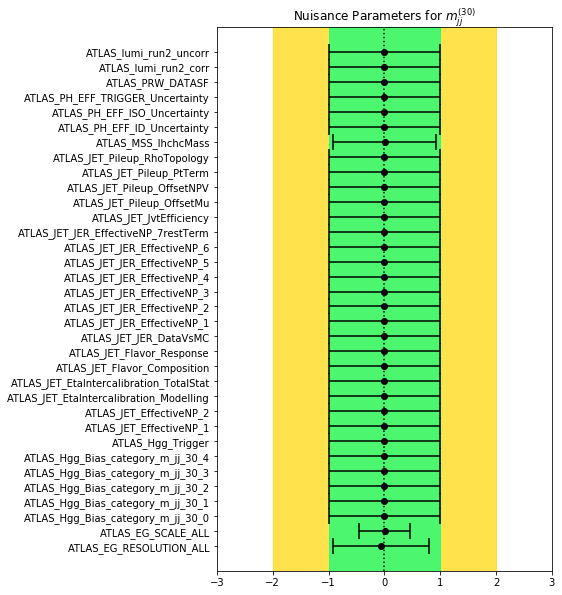

In [237]:
fig, ax = plt.subplots(figsize=(6, 10))
ax.errorbar(df_nui_fullfit['value'], 
          df_nui_fullfit.index,
          xerr=df_nui_fullfit['error'],
          color='Black', 
          fmt='o', 
          capsize=8, 
          capthick=1.5,
         )
ax.axvspan(-2, +2, color="gold", alpha=0.7)
ax.axvspan(-1, +1, color="springgreen", alpha=0.7)
ax.axvline(0, ls=':', color='Black')
ax.set_xlim(-3, 3)
quantity_latex_label = common.latex_labels[quantity].split(' ')[0]
ax.set_title("Nuisance Parameters for %s" % quantity_latex_label)

fig.savefig('{basedir}/systematic_pulls_{dataset}.png'.format(basedir=output_basedir_pulls, dataset=dataset),
            bbox_inches='tight')
fig.savefig('{basedir}/systematic_pulls_{dataset}.pdf'.format(basedir=output_basedir_pulls, dataset=dataset),
            bbox_inches='tight')

plt.show()

## Plotting correlation matrix for all $\mu$

In [ ]:
correlation = np.zeros((len(name_xsec_to_plot), len(name_xsec_to_plot)))
for i in range(len(name_xsec_to_plot)):
    for j in range(len(name_xsec_to_plot)):
        correlation[i, j] = fit_results_fullfit.correlation(name_xsec_to_plot[i], name_xsec_to_plot[j])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(correlation, dtype=np.bool))
ticklabels = df_poi_fullfit['bin_label']

sns.heatmap(correlation * 100,
            square=True,
            vmin=-40, vmax=40, center=0,
            annot=True,
            mask=mask,
            cmap=cmap,
            fmt='.1f',
            xticklabels=bin_labels_plot,
            yticklabels=bin_labels_plot,
            cbar_kws={'shrink':0.82}, ax=ax)
ax.set_title(common.latex_labels[quantity])

fig.savefig(os.path.join(output_basedir_correlation,
                         'correlation_{quantity}_{dataset}.pdf'.format(quantity=quantity, dataset=dataset)),
           bbox_inches='tight')
fig.savefig(os.path.join(output_basedir_correlation,
                         'correlation_{quantity}_{dataset}.png'.format(quantity=quantity, dataset=dataset)),
           bbox_inches='tight')


plt.show()

## $d\sigma_{fid}$ / $d p^{\gamma \gamma}_T$ plots

In [ ]:
theoretical_rel_errors = np.array(common.theoretical_relat_errors[quantity])

if len(theoretical_rel_errors) == nbins_plot - 1:
    print("==> PROBABLY OVERFLOW IS MISSING IN THEORETICAL ERRORS!!!, ADDING 0")
    theoretical_rel_errors = np.append(theoretical_rel_errors, 0)
theoretical_rel_errors

In [ ]:
def xsection_plot(binning_plot, bin_labels,
                  predicted_content, measured_content,
                  predicted_errors, measured_errors, measured_errors_stat_only,
                  log_scale, normalize_bin=False, ax=None): 
       
    bincenters = 0.5 * (binning_plot[1:] + binning_plot[:-1])
    binwidths = (binning_plot[1:] - binning_plot[:-1])
    
    if normalize_bin:
        predicted_content = predicted_content[:] / binwidths
        predicted_errors = predicted_errors[:] / binwidths
        measured_content = measured_content[:] / binwidths
        measured_errors = measured_errors[:] / binwidths
        measured_errors_stat_only = measured_errors_stat_only[:] / binwidths
       
      
        
    # SM xsections
    ax.bar(bincenters,
       predicted_errors * 2,
       bottom=(predicted_content - predicted_errors),
       width=binwidths,
       alpha=0.4, 
       zorder=0, 
       align='center'
      )
    
    ax.errorbar(bincenters, predicted_content,
        fmt='.',
        xerr=[binwidths/2, binwidths/2],
        label='SM prediction'
       )
    
    # measured xsections
    ax.errorbar(bincenters,
            measured_content,
            xerr=[binwidths / 2., binwidths / 2.],
            yerr=measured_errors,
            fmt='o',
            color='Black',
            label='data'
           )
    
    # measured xsection stat-only
    ax.errorbar(bincenters,
            measured_content,
            xerr=0,
            yerr=measured_errors_stat_only,
            capsize=5,
            fmt='o',
            color='Black',
           )

    
    ax.legend(loc=(0.6, 0.7), fontsize=18)

    if log_scale:
        if binning_plot[0] == 0:
            ax.set_xlim(binning_plot[0] + binwidths[0] * 0.25)
        ax.set_xscale('log')
    
    if bin_labels_plot is not None:
        ax.set_xticks(bincenters)
        ax.set_xticklabels(bin_labels_plot, rotation=90)
        
    return fig

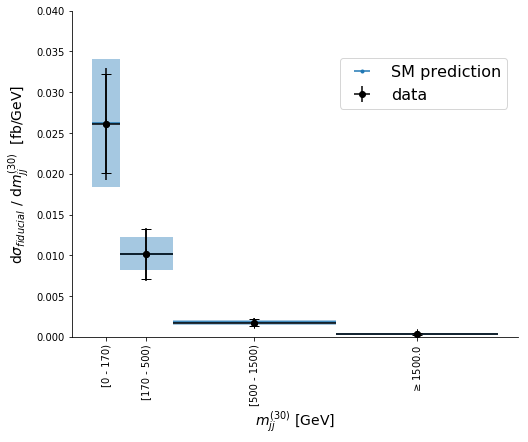

RuntimeError: Failed to open TrueType font

In [238]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_ylim(bottom=None, top=0.04)

xsection_plot(
    binning_plot, bin_labels_plot,
    xsections_SM_to_plot * common.Br * 1000,
    df_poi_fullfit['xsectionBr'].values * 1000,
    theoretical_rel_errors * xsections_SM_to_plot * common.Br * 1000,
    df_poi_fullfit['xsectionBr_error'].values * 1000,
    df_poi_statonly['xsectionBr_error'].values * 1000,
    do_log_x,
    normalize_bin=do_normalization, ax=ax)

ylabel = 'd$\sigma_{fiducial}$ / d%s' % str(latex_label.split('[')[0])
if unit:
    ylabel += ' [fb/GeV]'
else:
    ylabel += ' [fb]'
ax.set_ylabel(ylabel, fontsize=18)
ax.set_xlabel(latex_label, fontsize=18)

plt.show()

fig.savefig(os.path.join(output_basedir_xsections,
                         'xsection_{quantity}_{dataset}.pdf'.format(quantity=quantity, dataset=dataset)), bbox_inches='tight')
fig.savefig(os.path.join(output_basedir_xsections,
                         'xsection_{quantity}_{dataset}.png'.format(quantity=quantity, dataset=dataset)), bbox_inches='tight')